#### Script to read DMSP CDF files

In [8]:
from spacepy import pycdf

import numpy as np
import os
import pandas as pd
import datetime
import sys
from os.path import isfile, join
import glob

from random import *

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

from ovationpyme import ovation_prime
from ovationpyme import ovation_utilities

from geospacepy import omnireader
import time_hist2

import joblib


In [2]:
def dmsp_cdf_to_dataframe(directoryname,filename):
    ds = pycdf.CDF(os.path.join(directoryname,filename))
    
    print('Variables in the file: ')
    # See the variable names in the file
    for i in ds:
        print('variable name = {}'.format(i))
    print('\n\n')
    
    
    df = pd.DataFrame()
    channel_energies = ds['CHANNEL_ENERGIES'][...]
    df['datetime'] = pd.Series(ds['Epoch'][...])

    for i in ds:
        # DataFrame
        if (i == 'SC_GEOCENTRIC_LAT'):
            df[i] = pd.Series(ds[i][...])
        elif (i == 'SC_GEOCENTRIC_LON'):
            df[i] = pd.Series(ds[i][...])
        elif (i == 'SC_GEOCENTRIC_R'):
            df[i] = pd.Series(ds[i][...])
        elif (i == 'SC_AACGM_LAT'):
            df[i] = pd.Series(ds[i][...])
        elif (i == 'SC_AACGM_LON'):
            df[i] = pd.Series(ds[i][...])
        elif (i == 'SC_AACGM_LTIME'):
            df[i] = pd.Series(ds[i][...])
        elif (i == 'ELE_DIFF_ENERGY_FLUX'):
            for j in range(ds[i].shape[1]):
                df['ELE_DIFF_ENERGY_FLUX: channel energy=' + str(channel_energies[j])] = pd.Series(ds[i][:,j])
        elif (i == 'ELE_DIFF_ENERGY_FLUX_STD'):
            for j in range(ds[i].shape[1]):
                df['ELE_DIFF_ENERGY_FLUX_STD: channel energy=' + str(channel_energies[j])] = pd.Series(ds[i][:,j])
        elif (i == 'ELE_TOTAL_ENERGY_FLUX'):
            df[i] = pd.Series(ds[i][...])
        elif (i == 'ELE_TOTAL_ENERGY_FLUX_STD'):
            df[i] = pd.Series(ds[i][...])
        elif (i == 'ELE_AVG_ENERGY'):
            df[i] = pd.Series(ds[i][...])
        elif (i == 'ELE_AVG_ENERGY_STD'):
            df[i] = pd.Series(ds[i][...])
        elif (i == 'AURORAL_REGION'):
            df[i] = pd.Series(ds[i][...])
        elif (i == 'AURORAL_BOUNDARY_FOM'):
            df[i] = pd.Series(ds[i][...])
        elif (i == 'ORBIT_INDEX'):
            df[i] = pd.Series(ds[i][...])
            
    return df


def NewellCF_calc(v,bz,by):
    # v expected in km/s
    # b's expected in nT    
    NCF = np.zeros_like(v)
    NCF.fill(np.nan)
    bt = np.sqrt(by**2 + bz**2)
    bztemp = bz
    bztemp[bz == 0] = .001
    #Caculate clock angle (theta_c = t_c)
    tc = np.arctan2(by,bztemp)
    neg_tc = bt*np.cos(tc)*bz < 0 
    tc[neg_tc] = tc[neg_tc] + np.pi
    sintc = np.abs(np.sin(tc/2.))
    NCF = (v**1.33333)*(sintc**2.66667)*(bt**0.66667)
    return NCF

def nearest(items, pivot):
    #return min(items, key=lambda x: abs(x - pivot))
    return np.argmin(abs(items - pivot))


def outlier_detect_and_replace(df,str_id,outlier_value):
    """This function takes a dataframe, finds any columns 
    matching 'str_id' in the provided dataframe, and replaces
    all values that exceed the 'outlier_value' with NaN"""
#     print('working on {} outlier detection and removal'.format(str_id))
#     print('outlier value = {}'.format(outlier_value))

    cols = [ col for col in df.columns if str_id in col]
#     print('will detect and replace for columns = {}'.format(cols))
    for i in cols:
        df[i][ df[i] > outlier_value ] = np.NaN

    return df



# Metrics defined by 2019 GNSS FDL team
def dynamic_range_and_mae_loss(y_true, y_pred):
    mae = k.losses.mean_absolute_error(y_true, y_pred)
    dynamic_range_true = k.backend.max(y_true) - k.backend.min(y_true)
    dynamic_range_pred = k.backend.max(y_pred) - k.backend.min(y_pred)
    dynamic_range_loss = dynamic_range_true - dynamic_range_pred
    dynamic_range_loss = k.backend.mean(dynamic_range_loss)
    return mae + 0.1* dynamic_range_loss

def different_exponent(y_true, y_pred):
    # |x-y|^3 with dynamic range
    mae = k.backend.pow(k.backend.abs(y_true-y_pred),3)
    mae = k.backend.mean(mae)
    dynamic_range_true = k.backend.max(y_true) - k.backend.min(y_true)
    dynamic_range_pred = k.backend.max(y_pred) - k.backend.min(y_pred)
    dynamic_range_loss = dynamic_range_true - dynamic_range_pred
    dynamic_range_loss = k.backend.mean(dynamic_range_loss)
    return mae+ 0.1* dynamic_range_loss




##### Read in and examine DMSP data from March 17, 2015

In [3]:
filedirectory = '/Users/ryanmcgranaghan/Documents/DMSPdata/2015/'
filenames = ['dmsp-f16_ssj_precipitating-electrons-ions_20150317_v1.1.3.cdf',
             'dmsp-f17_ssj_precipitating-electrons-ions_20150317_v1.1.3.cdf',
             'dmsp-f18_ssj_precipitating-electrons-ions_20150317_v1.1.3.cdf']


df_f16 = dmsp_cdf_to_dataframe(filedirectory,filenames[0])
df_f16 = df_f16.set_index('datetime')
df_f16.index = pd.to_datetime(df_f16.index)
# df_f16

df_f17 = dmsp_cdf_to_dataframe(filedirectory,filenames[1])
df_f17 = df_f17.set_index('datetime')
df_f17.index = pd.to_datetime(df_f17.index)
# df_f17

df_f18 = dmsp_cdf_to_dataframe(filedirectory,filenames[2])
df_f18 = df_f18.set_index('datetime')
df_f18.index = pd.to_datetime(df_f18.index)
df_f18


Variables in the file: 
variable name = Epoch
variable name = SC_ECI
variable name = SC_ECI_LABEL
variable name = SC_GEOCENTRIC_LAT
variable name = SC_GEOCENTRIC_LON
variable name = SC_GEOCENTRIC_R
variable name = SC_AACGM_LAT
variable name = SC_AACGM_LON
variable name = SC_AACGM_LTIME
variable name = CHANNEL_ENERGIES
variable name = ELE_COUNTS_OBS
variable name = ELE_COUNTS_BKG
variable name = ELE_GEOMETRIC
variable name = ELE_DIFF_ENERGY_FLUX
variable name = ELE_DIFF_ENERGY_FLUX_STD
variable name = ELE_TOTAL_ENERGY_FLUX
variable name = ELE_TOTAL_ENERGY_FLUX_STD
variable name = ELE_AVG_ENERGY
variable name = ELE_AVG_ENERGY_STD
variable name = ION_COUNTS_OBS
variable name = ION_COUNTS_BKG
variable name = ION_GEOMETRIC
variable name = ION_DIFF_ENERGY_FLUX
variable name = ION_DIFF_ENERGY_FLUX_STD
variable name = ION_TOTAL_ENERGY_FLUX
variable name = ION_TOTAL_ENERGY_FLUX_STD
variable name = ION_AVG_ENERGY
variable name = ION_AVG_ENERGY_STD
variable name = AURORAL_REGION
variable name = O

SC_GEOCENTRIC_LAT  SC_GEOCENTRIC_LON  SC_GEOCENTRIC_R  \
datetime                                                                     
2015-03-17 00:00:00         -56.133195         100.596411      7241.902801   
2015-03-17 00:00:01         -56.189610         100.563694      7241.908824   
2015-03-17 00:00:02         -56.246017         100.530893      7241.914835   
2015-03-17 00:00:03         -56.302420         100.498007      7241.920835   
2015-03-17 00:00:04         -56.358814         100.465036      7241.926822   
2015-03-17 00:00:05         -56.415202         100.431981      7241.932798   
2015-03-17 00:00:06         -56.471582         100.398840      7241.938761   
2015-03-17 00:00:07         -56.527955         100.365613      7241.944712   
2015-03-17 00:00:08         -56.584321         100.332299      7241.950651   
2015-03-17 00:00:09         -56.640681         100.298898      7241.956579   
2015-03-17 00:00:10         -56.697035         100.265409      7241.962494   
2015-03-17 00:00:11         -56.753381         100.231833      7241.968397   
2015-03-17 00:00:12         -56.809719         100.198169      7241.974289   
2015-03-17 00:00:13         -56.866050         100.164416      7241.980168   
2015-03-17 00:00:14         -56.922374         100.130574      7241.986035   
2015-03-17 00:00:15         -56.978690         100.096642      7241.991890   
2015-03-17 00:00:16         -57.035000         100.062620      7241.997733   
2015-03-17 00:00:17         -57.091302         100.028508      7242.003564   
2015-03-17 00:00:18         -57.147599          99.994303      7242.009383   
2015-03-17 00:00:19         -57.203886          99.960009      7242.015190   
2015-03-17 00:00:20         -57.260166          99.925622      7242.020985   
2015-03-17 00:00:21         -57.316439          99.891143      7242.026768   
2015-03-17 00:00:22         -57.372704          99.856571      7242.032539   
2015-03-17 00:00:23         -57.428962          99.821906      7242.038298   
2015-03-17 00:00:24         -57.485212          99.787147      7242.044045   
2015-03-17 00:00:25         -57.541457          99.752292      7242.049780   
2015-03-17 00:00:26         -57.597692          99.717344      7242.055502   
2015-03-17 00:00:27         -57.653919          99.682300      7242.061213   
2015-03-17 00:00:28         -57.710138          99.647161      7242.066912   
2015-03-17 00:00:29         -57.766350          99.611926      7242.072598   
...                                ...                ...              ...   
2015-03-17 23:59:30         -77.387870         336.935426      7243.183463   
2015-03-17 23:59:31         -77.345509         336.746312      7243.180990   
2015-03-17 23:59:32         -77.303021         336.558414      7243.178507   
2015-03-17 23:59:33         -77.260406         336.371715      7243.176012   
2015-03-17 23:59:34         -77.217669         336.186222      7243.173507   
2015-03-17 23:59:35         -77.174808         336.001920      7243.170990   
2015-03-17 23:59:36         -77.131825         335.818799      7243.168463   
2015-03-17 23:59:37         -77.088722         335.636850      7243.165925   
2015-03-17 23:59:38         -77.045500         335.456066      7243.163376   
2015-03-17 23:59:39         -77.002159         335.276439      7243.160816   
2015-03-17 23:59:40         -76.958701         335.097958      7243.158245   
2015-03-17 23:59:41         -76.915126         334.920610      7243.155664   
2015-03-17 23:59:42         -76.871438         334.744400      7243.153071   
2015-03-17 23:59:43         -76.827636         334.569312      7243.150468   
2015-03-17 23:59:44         -76.783721         334.395339      7243.147854   
2015-03-17 23:59:45         -76.739695         334.222471      7243.145228   
2015-03-17 23:59:46         -76.695560         334.050701      7243.142592   
2015-03-17 23:59:47         -76.651314         333.880021      7243.139946   
2015-03-17 23:59:48         -76.606959     

In [4]:
df_f17

SC_GEOCENTRIC_LAT  SC_GEOCENTRIC_LON  SC_GEOCENTRIC_R  \
datetime                                                                     
2015-03-17 00:00:00          34.282846          98.183949      7221.433967   
2015-03-17 00:00:01          34.224923          98.166460      7221.436252   
2015-03-17 00:00:02          34.166997          98.148989      7221.438540   
2015-03-17 00:00:03          34.109068          98.131535      7221.440832   
2015-03-17 00:00:04          34.051140          98.114101      7221.443126   
2015-03-17 00:00:05          33.993210          98.096685      7221.445423   
2015-03-17 00:00:06          33.935279          98.079286      7221.447724   
2015-03-17 00:00:07          33.877347          98.061906      7221.450027   
2015-03-17 00:00:08          33.819413          98.044544      7221.452333   
2015-03-17 00:00:09          33.761477          98.027199      7221.454643   
2015-03-17 00:00:10          33.703538          98.009872      7221.456955   
2015-03-17 00:00:11          33.645600          97.992563      7221.459271   
2015-03-17 00:00:12          33.587660          97.975272      7221.461589   
2015-03-17 00:00:13          33.529719          97.957998      7221.463911   
2015-03-17 00:00:14          33.471777          97.940742      7221.466235   
2015-03-17 00:00:15          33.413833          97.923503      7221.468562   
2015-03-17 00:00:16          33.355887          97.906282      7221.470893   
2015-03-17 00:00:17          33.297941          97.889078      7221.473226   
2015-03-17 00:00:18          33.239990          97.871891      7221.475562   
2015-03-17 00:00:19          33.182041          97.854721      7221.477901   
2015-03-17 00:00:20          33.124090          97.837569      7221.480243   
2015-03-17 00:00:21          33.066137          97.820434      7221.482588   
2015-03-17 00:00:22          33.008184          97.803316      7221.484936   
2015-03-17 00:00:23          32.950229          97.786215      7221.487287   
2015-03-17 00:00:24          32.892272          97.769131      7221.489640   
2015-03-17 00:00:25          32.834312          97.752064      7221.491997   
2015-03-17 00:00:26          32.776353          97.735013      7221.494356   
2015-03-17 00:00:27          32.718393          97.717980      7221.496718   
2015-03-17 00:00:28          32.660431          97.700963      7221.499083   
2015-03-17 00:00:29          32.602468          97.683963      7221.501451   
...                                ...                ...              ...   
2015-03-17 23:59:30         -10.378147          90.562031      7223.128090   
2015-03-17 23:59:31         -10.436371          90.548456      7223.130456   
2015-03-17 23:59:32         -10.494595          90.534878      7223.132820   
2015-03-17 23:59:33         -10.552821          90.521296      7223.135183   
2015-03-17 23:59:34         -10.611044          90.507711      7223.137545   
2015-03-17 23:59:35         -10.669267          90.494123      7223.139905   
2015-03-17 23:59:36         -10.727489          90.480531      7223.142264   
2015-03-17 23:59:37         -10.785711          90.466935      7223.144621   
2015-03-17 23:59:38         -10.843933          90.453335      7223.146977   
2015-03-17 23:59:39         -10.902155          90.439732      7223.149331   
2015-03-17 23:59:40         -10.960376          90.426126      7223.151684   
2015-03-17 23:59:41         -11.018599          90.412515      7223.154035   
2015-03-17 23:59:42         -11.076819          90.398900      7223.156385   
2015-03-17 23:59:43         -11.135039          90.385282      7223.158734   
2015-03-17 23:59:44         -11.193259          90.371661      7223.161081   
2015-03-17 23:59:45         -11.251478          90.358035      7223.163427   
2015-03-17 23:59:46         -11.309697          90.344406      7223.165771   
2015-03-17 23:59:47         -11.367915          90.330773      7223.168114   
2015-03-17 23:59:48         -11.426136     

<IPython.core.display.Javascript object>


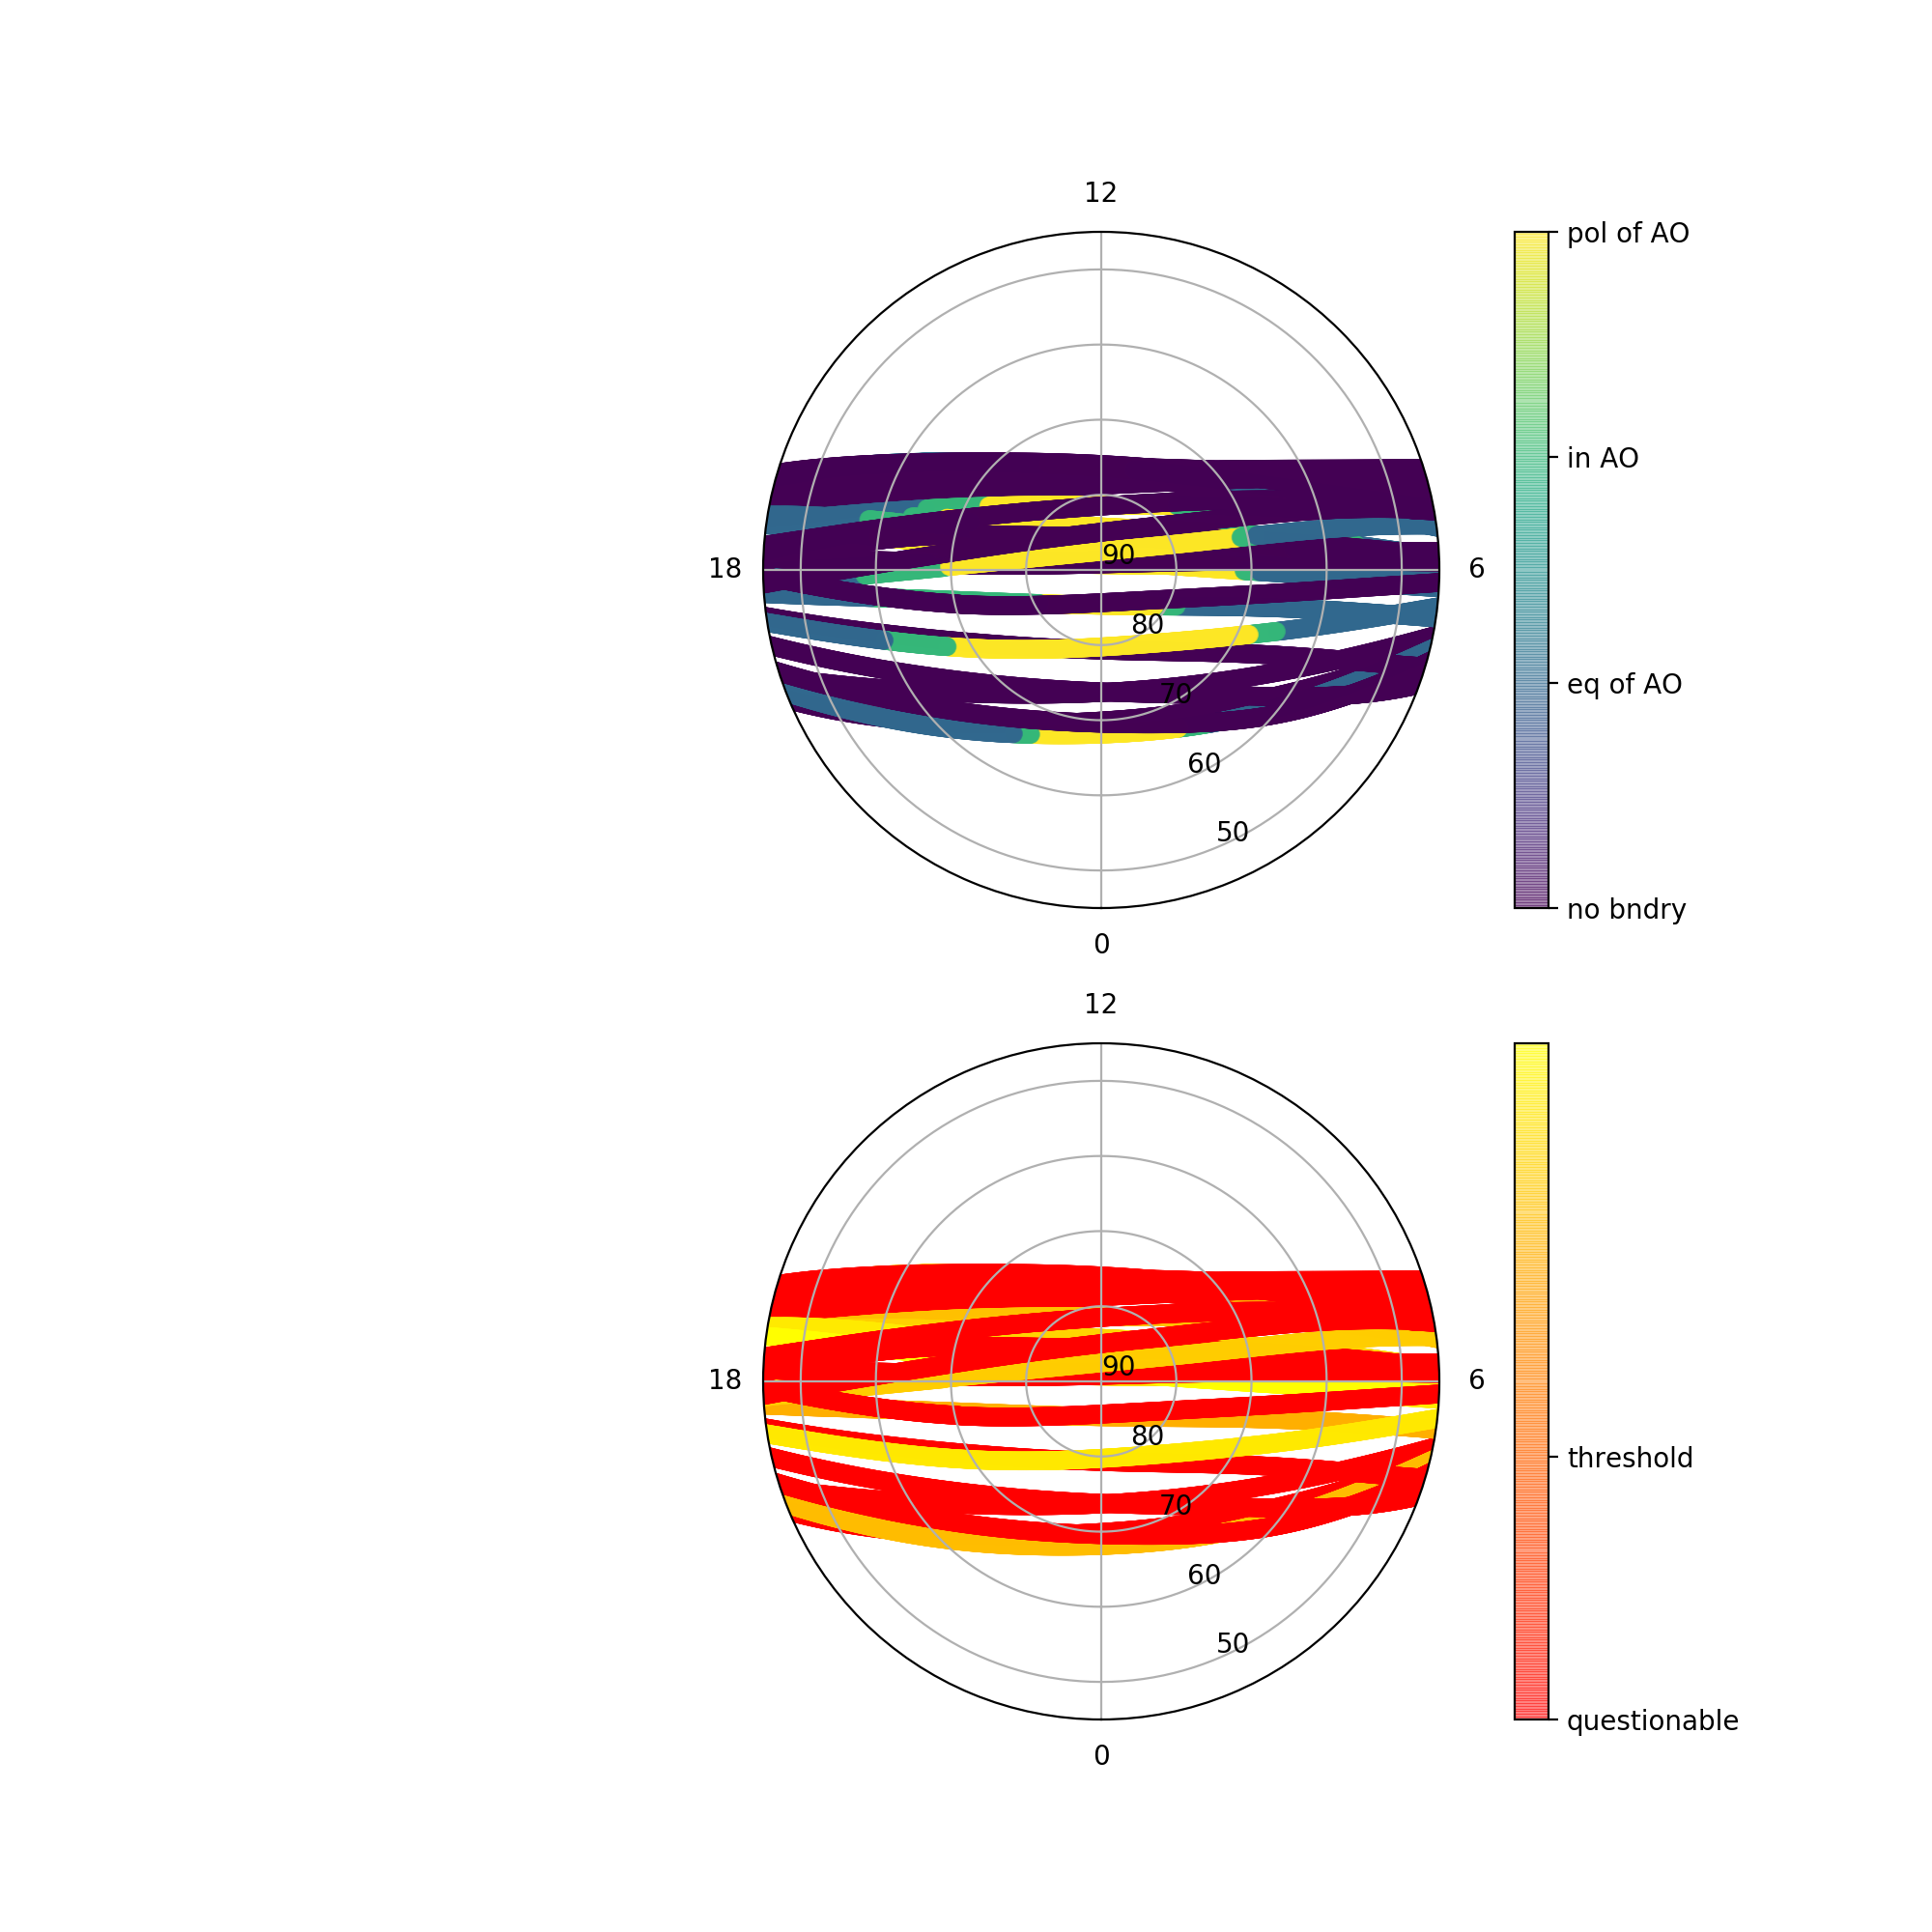

In [37]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10,10))

ax1 = plt.subplot(211,polar=True)
ctf = ax1.scatter(df_f17['SC_AACGM_LTIME'] / 24. * (2*np.pi),
                  90-np.abs(df_f17['SC_AACGM_LAT']),
#          '.',
         c=df_f17['AURORAL_REGION'],
         alpha=0.5)

cbar = fig.colorbar(ctf,ax=ax1,ticks=[0,1,2,3])#,extend='both')#,boundaries=[0,0.5,1.0,1.5],ticks=[0,0.5,1.0,1.5])
cbar.ax.set_yticklabels(['no bndry', 'eq of AO', 'in AO', 'pol of AO'])

# define your axis limits
ax1.set_ylim([0,45])

# Set the radius labels
ax1.set_yticks(np.arange(0,50,10))  # less radial ticks
ax1.set_yticklabels(90 - np.arange(0,50,10))  # less radial ticks

# Set the circumference labels
ax1.set_xticks(np.linspace(0, 2*np.pi, 4, endpoint=False))
ax1.set_xticklabels(('0','6','12','18'))      
# Make the labels go clockwise
# ax.set_theta_direction(-1)

ax1.grid(True)
ax1.set_theta_zero_location("S")



ax2 = plt.subplot(212,polar=True)
ctf = ax2.scatter(df_f17['SC_AACGM_LTIME'] / 24. * (2*np.pi),
                  90-np.abs(df_f17['SC_AACGM_LAT']),
#          '.',
         c=df_f17['AURORAL_BOUNDARY_FOM'],
         alpha=0.5,cmap='autumn')

cbar = fig.colorbar(ctf,ax=ax2,ticks=[0,1.7,5])#,extend='both')#,boundaries=[0,0.5,1.0,1.5],ticks=[0,0.5,1.0,1.5])
cbar.ax.set_yticklabels(['questionable','threshold','confident'])

# define your axis limits
ax2.set_ylim([0,45])

# Set the radius labels
ax2.set_yticks(np.arange(0,50,10))  # less radial ticks
ax2.set_yticklabels(90 - np.arange(0,50,10))  # less radial ticks

# Set the circumference labels
ax2.set_xticks(np.linspace(0, 2*np.pi, 4, endpoint=False))
ax2.set_xticklabels(('0','6','12','18'))      


ax2.grid(True)
ax2.set_theta_zero_location("S")
       
plt.show()
         

In [39]:
print(data_f16['ELE_TOTAL_ENERGY_FLUX'].attrs)


CATDESC: Electron total energy flux integrated over energy (eV/cm2/ster/s). [CDF_CHAR]
DEPEND_0: Epoch [CDF_CHAR]
DISPLAY_TYPE: time_series [CDF_CHAR]
FIELDNAM: ELE_TOTAL_ENERGY_FLUX [CDF_CHAR]
FILLVAL: nan [CDF_FLOAT]
FORMAT: E12.2 [CDF_CHAR]
LABLAXIS: ELE_TOTAL_ENERGY_FLUX [CDF_CHAR]
SCALETYP: log [CDF_CHAR]
UNITS: eV/cm2/ster/s [CDF_CHAR]
VALIDMAX: 1e+30 [CDF_FLOAT]
VALIDMIN: -1e+30 [CDF_FLOAT]
VAR_NOTES: Uncertainty represented in variable ELE_TOTAL_ENERGY_FLUX_STD [CDF_CHAR]
VAR_TYPE: data [CDF_CHAR]


In [13]:
print(data_f16['AURORAL_REGION'].attrs)

print()
print()

print(data_f16['AURORAL_BOUNDARY_FOM'].attrs)


print()
print()

print(data_f16['ORBIT_INDEX'].attrs)



CATDESC: Numerical code for auroral region of spacecraft location [CDF_CHAR]
DEPEND_0: Epoch [CDF_CHAR]
DISPLAY_TYPE: time_series [CDF_CHAR]
FIELDNAM: AURORAL_REGION [CDF_CHAR]
FILLVAL: nan [CDF_FLOAT]
FORMAT: E12.2 [CDF_CHAR]
LABLAXIS: AURORAL_REGION [CDF_CHAR]
SCALETYP: linear [CDF_CHAR]
UNITS: N/A [CDF_CHAR]
VALIDMAX: 3.0 [CDF_FLOAT]
VALIDMIN: 0.0 [CDF_FLOAT]
VAR_NOTES: 0 = No boundary identified,
1 = Equatorward of the auroral zone, 
2 = In the auroral zone, 
3 = Polar cap [CDF_CHAR]
VAR_TYPE: data [CDF_CHAR]


CATDESC: Figure of Merit for Auroral Boundary Determination [CDF_CHAR]
DEPEND_0: Epoch [CDF_CHAR]
DISPLAY_TYPE: time_series [CDF_CHAR]
FIELDNAM: AURORAL_BOUNDARY_FOM [CDF_CHAR]
FILLVAL: nan [CDF_FLOAT]
FORMAT: E12.2 [CDF_CHAR]
LABLAXIS: AURORAL_BOUNDARY_FOM [CDF_CHAR]
SCALETYP: linear [CDF_CHAR]
UNITS: N/A [CDF_CHAR]
VALIDMAX: 5.0 [CDF_FLOAT]
VALIDMIN: 0.0 [CDF_FLOAT]
VAR_NOTES: Typical range 0-3. Less than 1.7 is suspect.
Computed as ( FOM = A_xa/A_max + A_xd/A_max + DTa,d 

<IPython.core.display.Javascript object>


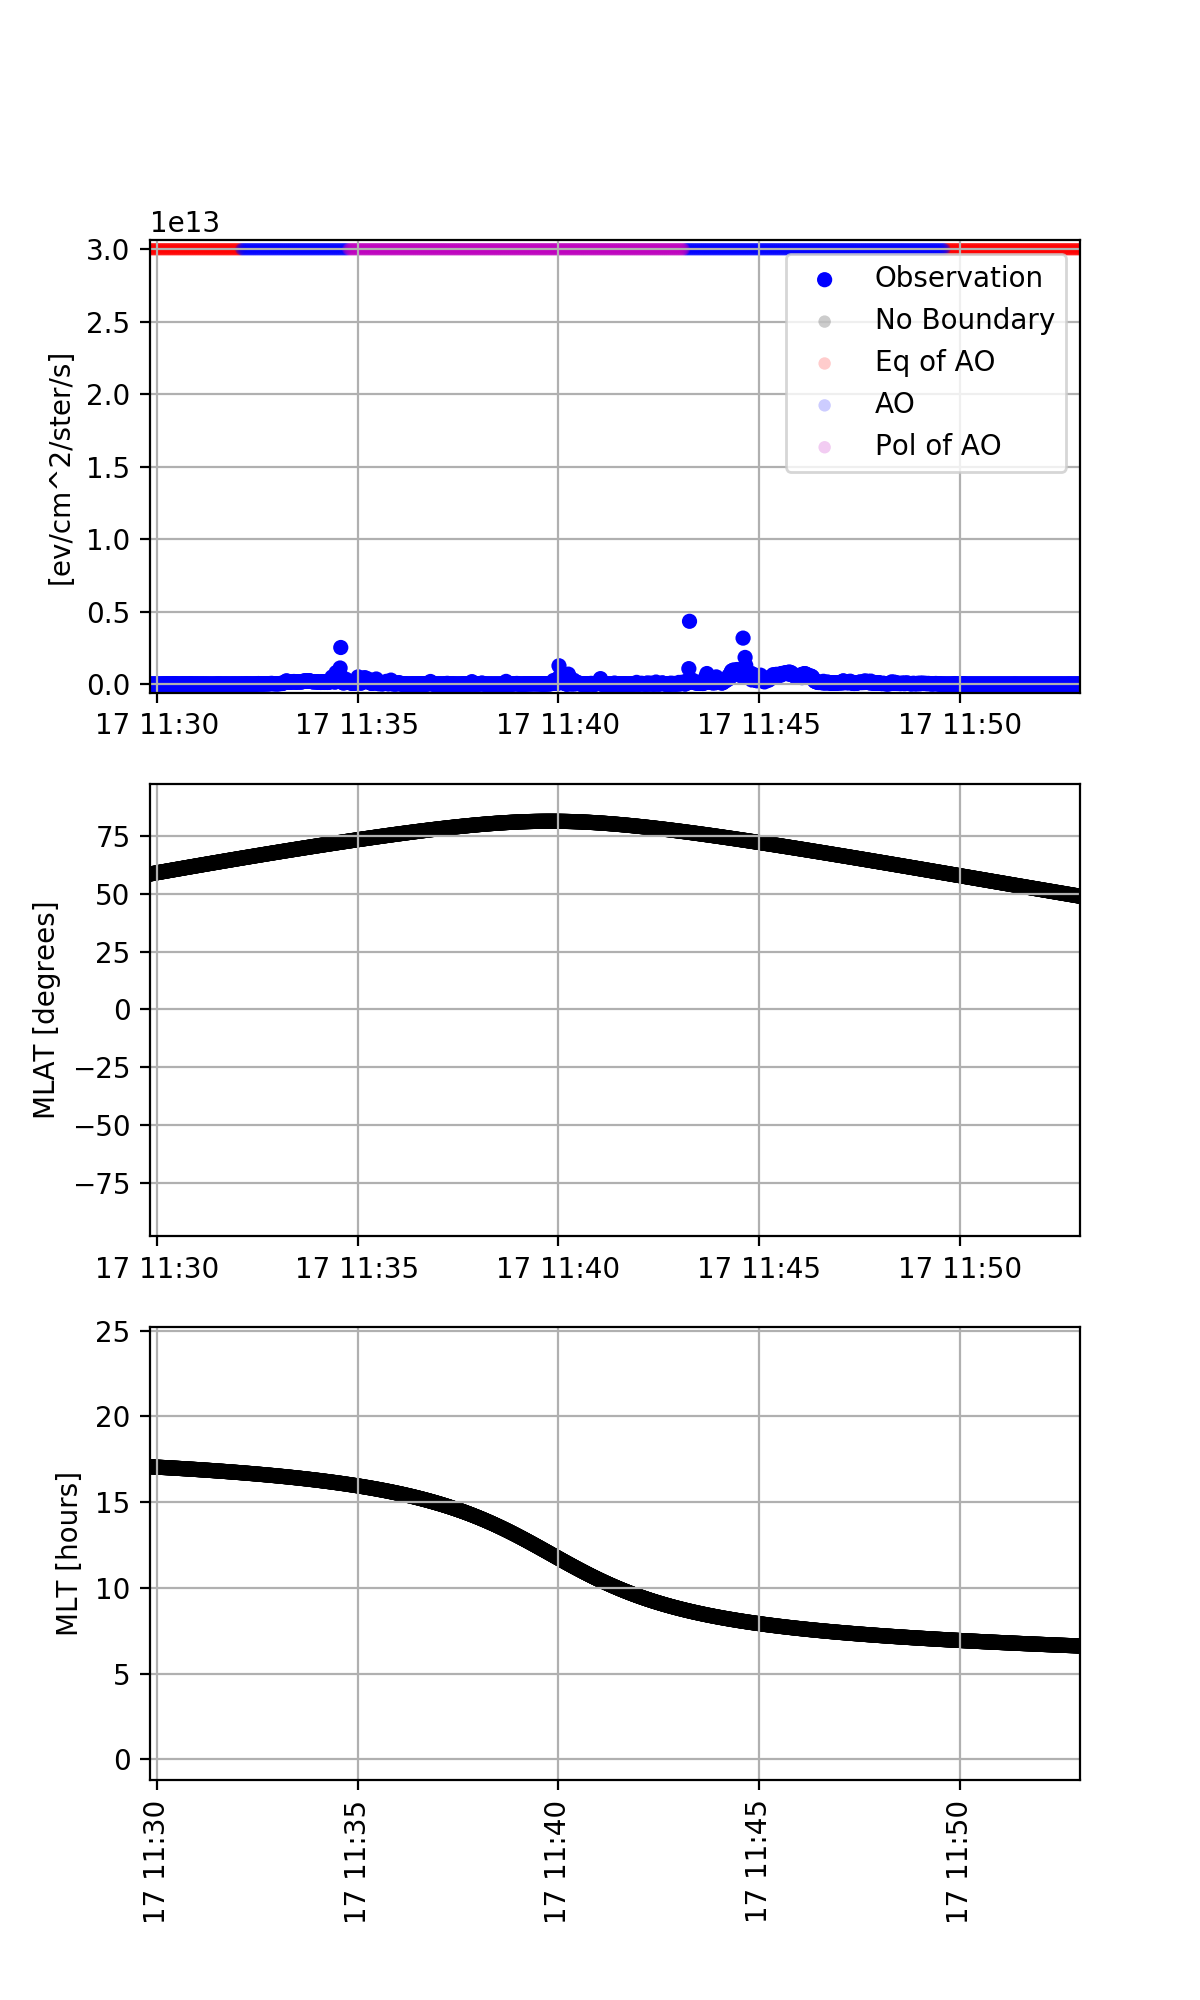

In [46]:
%matplotlib notebook
plt.ion()

fig = plt.figure(figsize=(6,10))
gs = GridSpec(3,1, figure=fig)

# ax0 = fig.add_subplot(gs[0,0])
ax0 = plt.subplot(gs[0,0])
ax_out0 = ax0.scatter(df_f17.index,
            df_f17['ELE_TOTAL_ENERGY_FLUX'],
            c = 'b',
            alpha = 1,
            s=30, 
            edgecolor='',
            label='Observation'
           )
ax0.scatter(df_f17[df_f17['AURORAL_REGION']==0].index,
            np.tile(3e13,(len(df_f17[df_f17['AURORAL_REGION']==0]),1)),
            c = 'k',
            alpha = 0.2,
            s=20, 
            edgecolor='',
            label='No Boundary'
           )
ax0.scatter(df_f17[df_f17['AURORAL_REGION']==1].index,
            np.tile(3e13,(len(df_f17[df_f17['AURORAL_REGION']==1]),1)),
            c = 'r',
            alpha = 0.2,
            s=20, 
            edgecolor='',
            label='Eq of AO'
           )
ax0.scatter(df_f17[df_f17['AURORAL_REGION']==2].index,
            np.tile(3e13,(len(df_f17[df_f17['AURORAL_REGION']==2]),1)),
            c = 'b',
            alpha = 0.2,
            s=20, 
            edgecolor='',
            label='AO'
           )
ax0.scatter(df_f17[df_f17['AURORAL_REGION']==3].index,
            np.tile(3e13,(len(df_f17[df_f17['AURORAL_REGION']==3]),1)),
            c = 'm',
            alpha = 0.2,
            s=20, 
            edgecolor='',
            label='Pol of AO'
           )

ax0.set_xlim([df_f17.index[0],df_f17.index[-1]])
ax0.grid(True)
ax0.set_ylabel('[ev/cm^2/ster/s]')
# ax0.set_ylabel('log10[ev/cm^2/s/str]')
ax0.set_xticklabels('')
ax0.legend()


ax3 = plt.subplot(gs[1,0],sharex=ax0)
ax_out = ax3.scatter(df_f17.index,
            df_f17['SC_AACGM_LAT'],
            alpha = 1.0,
            c = 'k',
            s=30, 
            edgecolor='',
           )
ax3.set_xlim([df_f17.index[0],df_f17.index[-1]])
ax3.grid(True)
ax3.set_ylabel('MLAT [degrees]')
ax3.set_xticklabels('')


ax4 = plt.subplot(gs[2,0],sharex=ax0)
ax_out = ax4.scatter(df_f17.index,
            df_f17['SC_AACGM_LTIME'],
            alpha = 1.0,
            c = 'k',
            s=30, 
            edgecolor='',
           )
ax4.set_xlim([df_f17.index[0],df_f17.index[-1]])
ax4.grid(True)
ax4.set_ylabel('MLT [hours]')
# ax4.set_xticklabels('')



plt.xticks(rotation = 90)

plt.show()

##### Generate ML validation data

###### Solar Wind Data

In [5]:
predict_datetimes = pd.date_range(start='3/17/2015', end='3/18/2015',freq="5min")
t_start = min(predict_datetimes) - datetime.timedelta(1)
t_end = max(predict_datetimes) + datetime.timedelta(1)

omniInt = omnireader.omni_interval(t_start,t_end,'5min', cdf_or_txt = 'txt')
omniInt_1hr = omnireader.omni_interval(t_start,t_end,'hourly', cdf_or_txt = 'txt')

# Get solar wind 5-minute data
epochs = omniInt['Epoch'] #time array for omni 5min data
Bx,By,Bz,AE,AL,AU,SymH = omniInt['BX_GSE'],omniInt['BY_GSM'],omniInt['BZ_GSM'],omniInt['AE_INDEX'],omniInt['AL_INDEX'],omniInt['AU_INDEX'], omniInt['SYM_H']
vsw,psw = omniInt['flow_speed'], omniInt['Pressure']
vx = omniInt['Vx']
PC = omniInt['PC_N_INDEX']
borovsky_reader = omnireader.borovsky(omniInt)
borovsky = borovsky_reader()

newell = NewellCF_calc(vsw, Bz, By)

idx = [0,len(Bz)]

epochs_1hr = omniInt_1hr['Epoch'] #datetime timestamps
F107,Kp = omniInt_1hr['F10_INDEX'],omniInt_1hr['KP']
f107_1hr_df = pd.DataFrame(F107,index=pd.to_datetime(epochs_1hr))
f107_5min_df_tmp = f107_1hr_df.copy().resample('5T').pad()
f107_5min_df = pd.DataFrame(index=epochs[idx[0]:idx[1]],columns=['F107'])
f107_5min_df['F107'].iloc[0:len(f107_5min_df_tmp)] = f107_5min_df_tmp.values.flatten()
f107_5min_df = f107_5min_df.ffill()
#     f107_5min_df = f107_5min_df.append(f107_5min_df.iloc[-1])


SW_df = pd.DataFrame(data = np.column_stack([epochs[idx[0]:idx[1]],f107_5min_df.iloc[idx[0]:idx[1]].values,Bz[idx[0]:idx[1]],By[idx[0]:idx[1]],Bx[idx[0]:idx[1]],AE[idx[0]:idx[1]],AL[idx[0]:idx[1]],AU[idx[0]:idx[1]],SymH[idx[0]:idx[1]],PC[idx[0]:idx[1]],vsw[idx[0]:idx[1]],vx[idx[0]:idx[1]],psw[idx[0]:idx[1]],borovsky[idx[0]:idx[1]],newell[idx[0]:idx[1]]]),
                     columns=['epochs','F107','Bz','By','Bx','AE','AL','AU','SymH','PC','vsw','vx','psw','borovsky','newell'])

SW_df.index = pd.DatetimeIndex( SW_df['epochs'] )
SW_df.drop( ['epochs'], axis=1, inplace=True)
SW_df = SW_df.fillna(method='ffill')

# Calculate the time histories of the OMNI data
SW_new = time_hist2.time_history(SW_df)
    # Returned by time_hist2 function as called: 
    #         A concatenated DataFrame containing
    #         - the original data
    #         - t-6hrs (1hr avg)
    #         - t-5hrs (1hr avg)
    #         - t-3hrs (30min avg)
    #         - t-1hrs (30min avg)
    #         - t-45min (instant)
    #         - t-30min (instant)
    #         - t-15min (instant)
    #         - t-10min (instant)
    #         - t-5min (instant)

# Resample the OMNI data to the cadence of the DMSP data (i.e., one second)
SW_df_1s = SW_new.copy().resample('1S').pad()


# # Remove unused columns 
# cols_to_drop_SW = [c for c in cols_to_drop_validation if c in SW_df_1s]
# SW_df_1s = SW_df_1s.drop(cols_to_drop_SW,axis=1)


# Clean the solar wind data
# IMF_outlier = 1000. #9999.99
IMF_outlier = 200. #9999.99
str_id = 'B'
SW_df = outlier_detect_and_replace(SW_df,str_id,IMF_outlier)
SW_df_1s = outlier_detect_and_replace(SW_df_1s,str_id,IMF_outlier)

print('--------------------------------------------------------------')

# vsw_outlier = 10000. #99999.9
vsw_outlier = 2000. #99999.9
str_id = 'vsw'
SW_df = outlier_detect_and_replace(SW_df,str_id,vsw_outlier)
SW_df_1s = outlier_detect_and_replace(SW_df_1s,str_id,vsw_outlier)

print('--------------------------------------------------------------')

# vsw_outlier = 10000. #99999.9
vsw_outlier = 2000. #99999.9
str_id = 'vx'
SW_df = outlier_detect_and_replace(SW_df,str_id,vsw_outlier)
SW_df_1s = outlier_detect_and_replace(SW_df_1s,str_id,vsw_outlier)

print('--------------------------------------------------------------')

# borovsky_outlier = 1e6 #df['borovsky'].quantile(.90)
borovsky_outlier = 1e5 #df['borovsky'].quantile(.90)
str_id = 'borovsky'
SW_df = outlier_detect_and_replace(SW_df,str_id,borovsky_outlier)
SW_df_1s = outlier_detect_and_replace(SW_df_1s,str_id,borovsky_outlier)

print('--------------------------------------------------------------')

# newell_outlier = 1e5 #df['newell'].quantile(.90)
newell_outlier = 9e3 #df['newell'].quantile(.90)
str_id = 'newell'
SW_df = outlier_detect_and_replace(SW_df,str_id,newell_outlier)
SW_df_1s = outlier_detect_and_replace(SW_df_1s,str_id,newell_outlier)

print('--------------------------------------------------------------')


# ----------------------------------------------------------------------------------
#           Forward fill the dataframes
# ----------------------------------------------------------------------------------

SW_df = SW_df.fillna(method='ffill')
SW_df_1s = SW_df_1s.fillna(method='ffill')
# RMM 4.6.2020 - for times when start of the time period is missing data, need a back fill command, too


# ----------------------------------------------------------------------------------
#           Save dataframe
# ----------------------------------------------------------------------------------


SW_df.to_csv(os.path.join(filedirectory,'SW_data.csv'),na_rep='NaN',index=True,header=True)
SW_df_1s.to_csv(os.path.join(filedirectory,'SW_data_1s.csv'),na_rep='NaN',index=True,header=True)


Created interval between 2015-03-16 and 2015-03-19, cadence 5min, start index 21312, end index 22176
Created interval between 2015-03-16 and 2015-03-19, cadence hourly, start index 1776, end index 1848
Applying transform Hourly Kp*10 -> Kp to omni hourly variable KP
--------------------------------------------------------------
--------------------------------------------------------------
--------------------------------------------------------------
--------------------------------------------------------------
--------------------------------------------------------------


/anaconda3/envs/python36/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


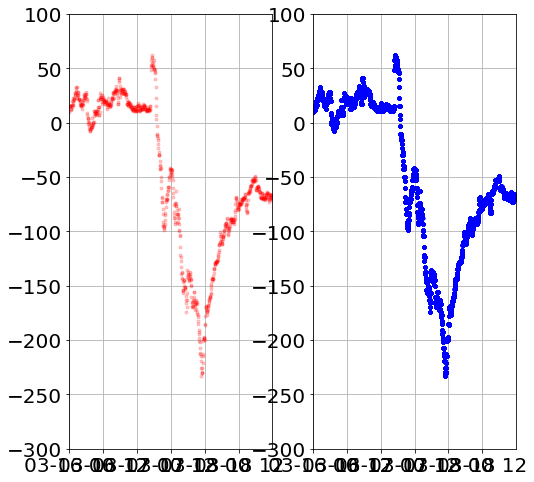

In [6]:
plt.figure(figsize=(8,8))

plt.subplot(121)
plt.plot(SW_df.index,SW_df['SymH'].values,'.',c='r',alpha=0.2)
plt.xlim([np.min(SW_df.index),np.max(SW_df.index)])
plt.ylim([-300,100])
plt.grid(True)

plt.subplot(122)
plt.plot(SW_df_1s.index,SW_df_1s['SymH'].values,'.',c='b',alpha=0.2)
plt.xlim([np.min(SW_df.index),np.max(SW_df.index)])
plt.ylim([-300,100])
plt.grid(True)

plt.show()

###### Get the grid on which to predict

In [6]:
latres = 0.5
ltres = 0.25
mlats = np.arange(45,90,latres)
mlts = np.arange(0,24,ltres)
# mlts = np.append(mlts,[0])

xgrid, ygrid = np.meshgrid(mlts,mlats)
# ygrid emulates ovation mlat grid
# xgrid emulates ovation mlt grid


# ----------------------------------------------------------------------------------
#           Prepare ovation prime conductance estimator
# ----------------------------------------------------------------------------------
numFluxThreshold = 5.0e7 # Value pulled from OvationPyme and used to set avg electron energies to zero for low number fluxes
auroral_flux_types = ['diff','mono','wave']
hemi = 'N'
estimator = ovation_prime.FluxEstimator(auroral_flux_types[0],energy_or_number='energy')
# Sample call and call once to get grid information
mlat_grid_ovation, mlt_grid_ovation, eFlux_ovation_tmp = estimator.get_flux_for_time(datetime.datetime(2010,1,1,0,0,0),
                                                                                 hemi='N',
                                                                                 return_dF=False,
                                                                                 combine_hemispheres=True,)
                
del eFlux_ovation_tmp
# ----------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------



Cached OMNI called for 2010-01-01 00:00:00
Created new OI: 2009-12-30 12:00:00-2010-01-02 12:00:00


In [7]:
grid_res = 'fine' #'coarse'

if (grid_res == 'fine'):
    mlat_grid = xgrid.copy()
    mlt_grid = ygrid.copy()
    
elif (grid_res == 'coarse'):
    
    mlat_grid = (mlat_grid_ovation).copy()
    mlt_grid = mlt_grid_ovation.copy()
    mlt_grid[mlt_grid < 0] = 24+mlt_grid[mlt_grid < 0]

shape_grid_flat = mlt_grid.shape[0]*mlt_grid.shape[1]
if (shape_grid_flat != mlat_grid.shape[0]*mlat_grid.shape[1]):
    print('something is wrong - flattened mlat and mlt grids are not equal!')

sin_mlt_grid = np.sin(2*np.pi*mlt_grid/24.)
cos_mlt_grid = np.cos(2*np.pi*mlt_grid/24.)

predict_locations = np.array(
                          (np.reshape( mlat_grid,(shape_grid_flat) ),
                           np.reshape( sin_mlt_grid,(shape_grid_flat) ),
                           np.reshape( cos_mlt_grid,(shape_grid_flat) ),
                          )
                         ).T

In [8]:
predict_locations.shape

(8640, 3)

##### Load an ML model


In [9]:
# Load NN model


# from keras import backend as K
import keras as k
from keras import utils, models, layers, optimizers
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

import tensorflow as tf
from keras.models import load_model


# ml_directory = '/Users/ryanmcgranaghan/Documents/DMSPdata/data/Jan25_2000_event/ML_model_80epochs_400batchsize_005000learningrate_3hiddenlayers__different_exponent/'

# ml_model_save_file = os.path.join(ml_directory,'ML_model_80epochs_400batchsize_005000learningrate_3hiddenlayers_70InputFeatures__different_exponent.h5')
# print('\n\nloading ML model: \n    {}\n\n'.format(ml_model_save_file))

# model = load_model(ml_model_save_file,custom_objects={'different_exponent':different_exponent})

# input_features_labels = [line.rstrip('\n') for line in open(os.path.join(ml_directory,'inputfeature_labels.txt'))]
# print('input features for this ML model = {}'.format(input_features_labels))

# # load the input feature scaler 
# from pickle import load
# scaler_X = load(open(os.path.join(ml_directory,'input_data_scaler.pkl'), 'rb'))



ml_directory1 = '/Users/ryanmcgranaghan/Documents/DMSPdata/data/Jan25_2000_event/ML_model_80epochs_400batchsize_005000learningrate_3hiddenlayers__mae/'
ml_model_save_file1 = os.path.join(ml_directory1,'ML_model_80epochs_400batchsize_005000learningrate_3hiddenlayers_70InputFeatures__mae.h5')
model_NN_mae = load_model(ml_model_save_file1)

print('------\n\n    NOTE: this assumes that input feature set to all ML models is the same and the scaler is consistent\n\n------')


input_features_labels = [line.rstrip('\n') for line in open(os.path.join(ml_directory1,'inputfeature_labels.txt'))]
print('input features for this ML model = {}'.format(input_features_labels))

# load the input feature scaler 
from pickle import load
scaler_X = load(open(os.path.join(ml_directory1,'input_data_scaler.pkl'), 'rb'))


ml_directory7 = '/Users/ryanmcgranaghan/Documents/DMSPdata/data/Jan25_2000_event/ML_model_80epochs_400batchsize_005000learningrate_3hiddenlayers__dynamic_range_and_mae_loss/'
ml_model_save_file7 = os.path.join(ml_directory7,'ML_model_80epochs_400batchsize_005000learningrate_3hiddenlayers_70InputFeatures__dynamic_range_and_mae_loss.h5')
model_NN_DRMAE = load_model(ml_model_save_file7,custom_objects={'dynamic_range_and_mae_loss':dynamic_range_and_mae_loss})


# Load LGBM Model
ml_directory_lgbm = '/Users/ryanmcgranaghan/Documents/DMSPdata/data/Jan25_2000_event/ML_LGBMmodel_190numestimators_48numleaves_dartboostingtype_3500learningrate/'
ml_model_save_file_lgbm = os.path.join(ml_directory_lgbm,'ML_model_LGBM70InputFeatures.joblib')
model_LGBM = joblib.load(ml_model_save_file_lgbm)




------

    NOTE: this assumes that input feature set to all ML models is the same and the scaler is consistent

------
input features for this ML model = ['SC_AACGM_LAT', 'ID_SC', 'sin_ut', 'cos_ut', 'sin_doy', 'cos_doy', 'sin_SC_AACGM_LTIME', 'cos_SC_AACGM_LTIME', 'F107', 'Bz', 'By', 'Bx', 'AL', 'AU', 'SymH', 'PC', 'vsw', 'vx', 'psw', 'Bz_6hr', 'By_6hr', 'Bx_6hr', 'AL_6hr', 'AU_6hr', 'SymH_6hr', 'PC_6hr', 'vsw_6hr', 'vx_6hr', 'psw_6hr', 'Bz_3hr', 'By_3hr', 'Bx_3hr', 'AL_3hr', 'AU_3hr', 'SymH_3hr', 'PC_3hr', 'vsw_3hr', 'vx_3hr', 'psw_3hr', 'Bz_1hr', 'By_1hr', 'Bx_1hr', 'AL_1hr', 'AU_1hr', 'SymH_1hr', 'PC_1hr', 'vsw_1hr', 'vx_1hr', 'psw_1hr', 'Bz_30min', 'By_30min', 'Bx_30min', 'AL_30min', 'AU_30min', 'SymH_30min', 'PC_30min', 'vsw_30min', 'vx_30min', 'psw_30min', 'Bz_10min', 'By_10min', 'Bx_10min', 'AL_10min', 'AU_10min', 'SymH_10min', 'PC_10min', 'vsw_10min', 'vx_10min', 'psw_10min']


In [10]:
df_f17_reduced = df_f17.copy(deep=True)
print(df_f17_reduced.shape)
df_f17_reduced = df_f17_reduced[ (df_f17_reduced['SC_AACGM_LAT'] > 45.) ]
print(df_f17_reduced.shape)
 

(86400, 51)
(22290, 51)


###### Create the predictions at each time step - only at DMSP locations

In [11]:
%time

predictions_input_list = input_features_labels
y_loop_predictions_save = pd.DataFrame(index=df_f17_reduced.index,
                                       columns=predictions_input_list+['predictions-NN MAE','predictions-NN DRMAE','predictions-LGBM'])

ctr = 0
for d in df_f17_reduced.index:
    
    if np.mod(ctr,500)==0.:
        print('working on datetime = {}'.format(d))
    ctr += 1

    doy_loop = d.timetuple().tm_yday
    ut_loop = d.hour*3600 + d.minute*60 + d.second

    doy_sin_loop = np.sin(2*np.pi*doy_loop/365.)
    doy_cos_loop = np.cos(2*np.pi*doy_loop/365.)

    ut_sin_loop = np.sin(2*np.pi*ut_loop/86400.)
    ut_cos_loop = np.cos(2*np.pi*ut_loop/86400.)

    df_loop = pd.DataFrame(columns=predictions_input_list)

    idx_SW_loop = nearest(SW_df_1s.index,d)
#     print('nearest index in solar wind data is {} (datetime = {})'.format(idx_SW_loop,SW_df_1s.index[idx_SW_loop]))
    SW_data_loop = SW_df_1s.iloc[idx_SW_loop]

    idx_dmsp = nearest(d,df_f17_reduced.index)
#     print(idx_dmsp)
    df_loop['SC_AACGM_LAT'] = [df_f17_reduced['SC_AACGM_LAT'][idx_dmsp]]
    df_loop['sin_SC_AACGM_LTIME'] = [np.sin(2*np.pi*(df_f17_reduced['SC_AACGM_LTIME'][idx_dmsp])/24.)]
    df_loop['cos_SC_AACGM_LTIME'] = [np.cos(2*np.pi*(df_f17_reduced['SC_AACGM_LTIME'][idx_dmsp])/24.)]

    df_loop['ID_SC'] = 17.0

    df_loop['sin_ut'] = ut_sin_loop
    df_loop['cos_ut'] = ut_cos_loop

    df_loop['sin_doy'] = doy_sin_loop
    df_loop['cos_doy'] = doy_cos_loop


    for col in df_loop.columns:
        if (col in SW_df_1s.columns):
            df_loop[col] = SW_df_1s[col].iloc[idx_SW_loop]

    # Quick catch for bad data
    if (np.any(pd.isnull(df_loop.values[0,:]))):
        print('\n\n\n\nWARNING: input data had NaN value(s) at datetime = {}\n\n\n\n'.format(d))


#     print('data_loop shape = {}'.format(df_loop.shape))
    
    

    # ----------------------------------------------------------------------------------
    #           Make Predictions
    # ----------------------------------------------------------------------------------
    y_loop_predictions_NN_MAE = model_NN_mae.predict( scaler_X.transform(df_loop.values) )
    y_loop_predictions_NN_DRMAE = model_NN_DRMAE.predict( scaler_X.transform(df_loop.values) )
    y_loop_predictions_LGBM = model_LGBM.predict( scaler_X.transform(df_loop.values) )
    
    y_loop_predictions_save.loc[y_loop_predictions_save.index==d,'predictions-NN MAE'] = y_loop_predictions_NN_MAE
    y_loop_predictions_save.loc[y_loop_predictions_save.index==d,'predictions-NN DRMAE'] = y_loop_predictions_NN_DRMAE
    y_loop_predictions_save.loc[y_loop_predictions_save.index==d,'predictions-LGBM'] = y_loop_predictions_LGBM
    y_loop_predictions_save.loc[y_loop_predictions_save.index==d,df_loop.columns] = df_loop.values

#     y_loop_predictions_save['datetimes'].iloc[-1] = d
#     print('{}\n  {}'.format(y_loop_predictions_save.index[-1],y_loop_predictions_save.shape))
    # ----------------------------------------------------------------------------------
    # ----------------------------------------------------------------------------------
#     print(y_loop_predictions)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.11 µs
working on datetime = 2015-03-17 01:10:32
working on datetime = 2015-03-17 01:18:52
working on datetime = 2015-03-17 01:27:12
working on datetime = 2015-03-17 01:35:32
working on datetime = 2015-03-17 02:59:18
working on datetime = 2015-03-17 03:07:38
working on datetime = 2015-03-17 03:15:58
working on datetime = 2015-03-17 04:41:06
working on datetime = 2015-03-17 04:49:26
working on datetime = 2015-03-17 04:57:46
working on datetime = 2015-03-17 06:23:52
working on datetime = 2015-03-17 06:32:12
working on datetime = 2015-03-17 06:40:32
working on datetime = 2015-03-17 08:06:45
working on datetime = 2015-03-17 08:15:05
working on datetime = 2015-03-17 08:23:25
working on datetime = 2015-03-17 09:48:35
working on datetime = 2015-03-17 09:56:55
working on datetime = 2015-03-17 10:05:15
working on datetime = 2015-03-17 11:28:11
working on datetime = 2015-03-17 11:36:31
working on datetime = 2015-03-17 11:44:51
working on d

KeyboardInterrupt: 

In [12]:

y_loop_predictions_save



SC_AACGM_LAT ID_SC    sin_ut    cos_ut  sin_doy   cos_doy  \
datetime                                                                        
2015-03-17 01:10:32      45.0224    17  0.302924  0.953015  0.96574  0.259512   
2015-03-17 01:10:33      45.0706    17  0.302994  0.952993  0.96574  0.259512   
2015-03-17 01:10:34      45.1188    17  0.303063  0.952971  0.96574  0.259512   
2015-03-17 01:10:35      45.1671    17  0.303132  0.952948  0.96574  0.259512   
2015-03-17 01:10:36      45.2153    17  0.303202  0.952926  0.96574  0.259512   
2015-03-17 01:10:37      45.2635    17  0.303271  0.952904  0.96574  0.259512   
2015-03-17 01:10:38      45.3118    17   0.30334  0.952882  0.96574  0.259512   
2015-03-17 01:10:39        45.36    17  0.303409   0.95286  0.96574  0.259512   
2015-03-17 01:10:40      45.4083    17  0.303479  0.952838  0.96574  0.259512   
2015-03-17 01:10:41      45.4566    17  0.303548  0.952816  0.96574  0.259512   
2015-03-17 01:10:42      45.5048    17  0.303617  0.952794  0.96574  0.259512   
2015-03-17 01:10:43      45.5531    17  0.303687  0.952772  0.96574  0.259512   
2015-03-17 01:10:44      45.6015    17  0.303756   0.95275  0.96574  0.259512   
2015-03-17 01:10:45      45.6498    17  0.303825  0.952728  0.96574  0.259512   
2015-03-17 01:10:46      45.6981    17  0.303894  0.952706  0.96574  0.259512   
2015-03-17 01:10:47      45.7464    17  0.303964  0.952684  0.96574  0.259512   
2015-03-17 01:10:48      45.7947    17  0.304033  0.952661  0.96574  0.259512   
2015-03-17 01:10:49      45.8431    17  0.304102  0.952639  0.96574  0.259512   
2015-03-17 01:10:50      45.8914    17  0.304172  0.952617  0.96574  0.259512   
2015-03-17 01:10:51      45.9398    17  0.304241  0.952595  0.96574  0.259512   
2015-03-17 01:10:52      45.9881    17   0.30431  0.952573  0.96574  0.259512   
2015-03-17 01:10:53      46.0365    17  0.304379  0.952551  0.96574  0.259512   
2015-03-17 01:10:54      46.0849    17  0.304449  0.952529  0.96574  0.259512   
2015-03-17 01:10:55      46.1333    17  0.304518  0.952507  0.96574  0.259512   
2015-03-17 01:10:56      46.1817    17  0.304587  0.952484  0.96574  0.259512   
2015-03-17 01:10:57      46.2301    17  0.304657  0.952462  0.96574  0.259512   
2015-03-17 01:10:58      46.2785    17  0.304726   0.95244  0.96574  0.259512   
2015-03-17 01:10:59      46.3269    17  0.304795  0.952418  0.96574  0.259512   
2015-03-17 01:11:00      46.3754    17  0.304864  0.952396  0.96574  0.259512   
2015-03-17 01:11:01      46.4238    17  0.304934  0.952374  0.96574  0.259512   
...                          ...   ...       ...       ...      ...       ...   
2015-03-17 23:42:38          NaN   NaN       NaN       NaN      NaN       NaN   
2015-03-17 23:42:39          NaN   NaN       NaN       NaN      NaN       NaN   
2015-03-17 23:42:40          NaN   NaN       NaN       NaN      NaN       NaN   
2015-03-17 23:42:41          NaN   NaN       NaN       NaN      NaN       NaN   
2015-03-17 23:42:42          NaN   NaN       NaN       NaN      NaN       NaN   
2015-03-17 23:42:43          NaN   NaN       NaN       NaN      NaN       NaN   
2015-03-17 23:42:44          NaN   NaN       NaN       NaN      NaN       NaN   
2015-03-17 23:42:45          NaN   NaN       NaN       NaN      NaN       NaN   
2015-03-17 23:42:46          NaN   NaN       NaN       NaN      NaN       NaN   
2015-03-17 23:42:47          NaN   NaN       NaN       NaN      NaN       NaN   
2015-03-17 23:42:48          NaN   NaN       NaN       NaN      NaN       NaN   
2015-03-17 23:42:49          NaN   NaN       NaN       NaN      NaN       NaN   
2015-03-17 23:42:50          NaN   NaN       NaN       NaN      NaN       NaN   
2015-03-17 23:42:51          NaN   NaN       NaN       NaN      NaN       NaN   
2015-03-17 23:42:52          NaN   NaN       NaN       NaN      NaN       NaN   
2015-03-17 23:42:53          NaN   NaN       NaN       NaN      NaN       NaN   
2015-03-17 23:42:54          NaN   NaN       NaN   

##### Visualize the predictions and DMSP data


<IPython.core.display.Javascript object>


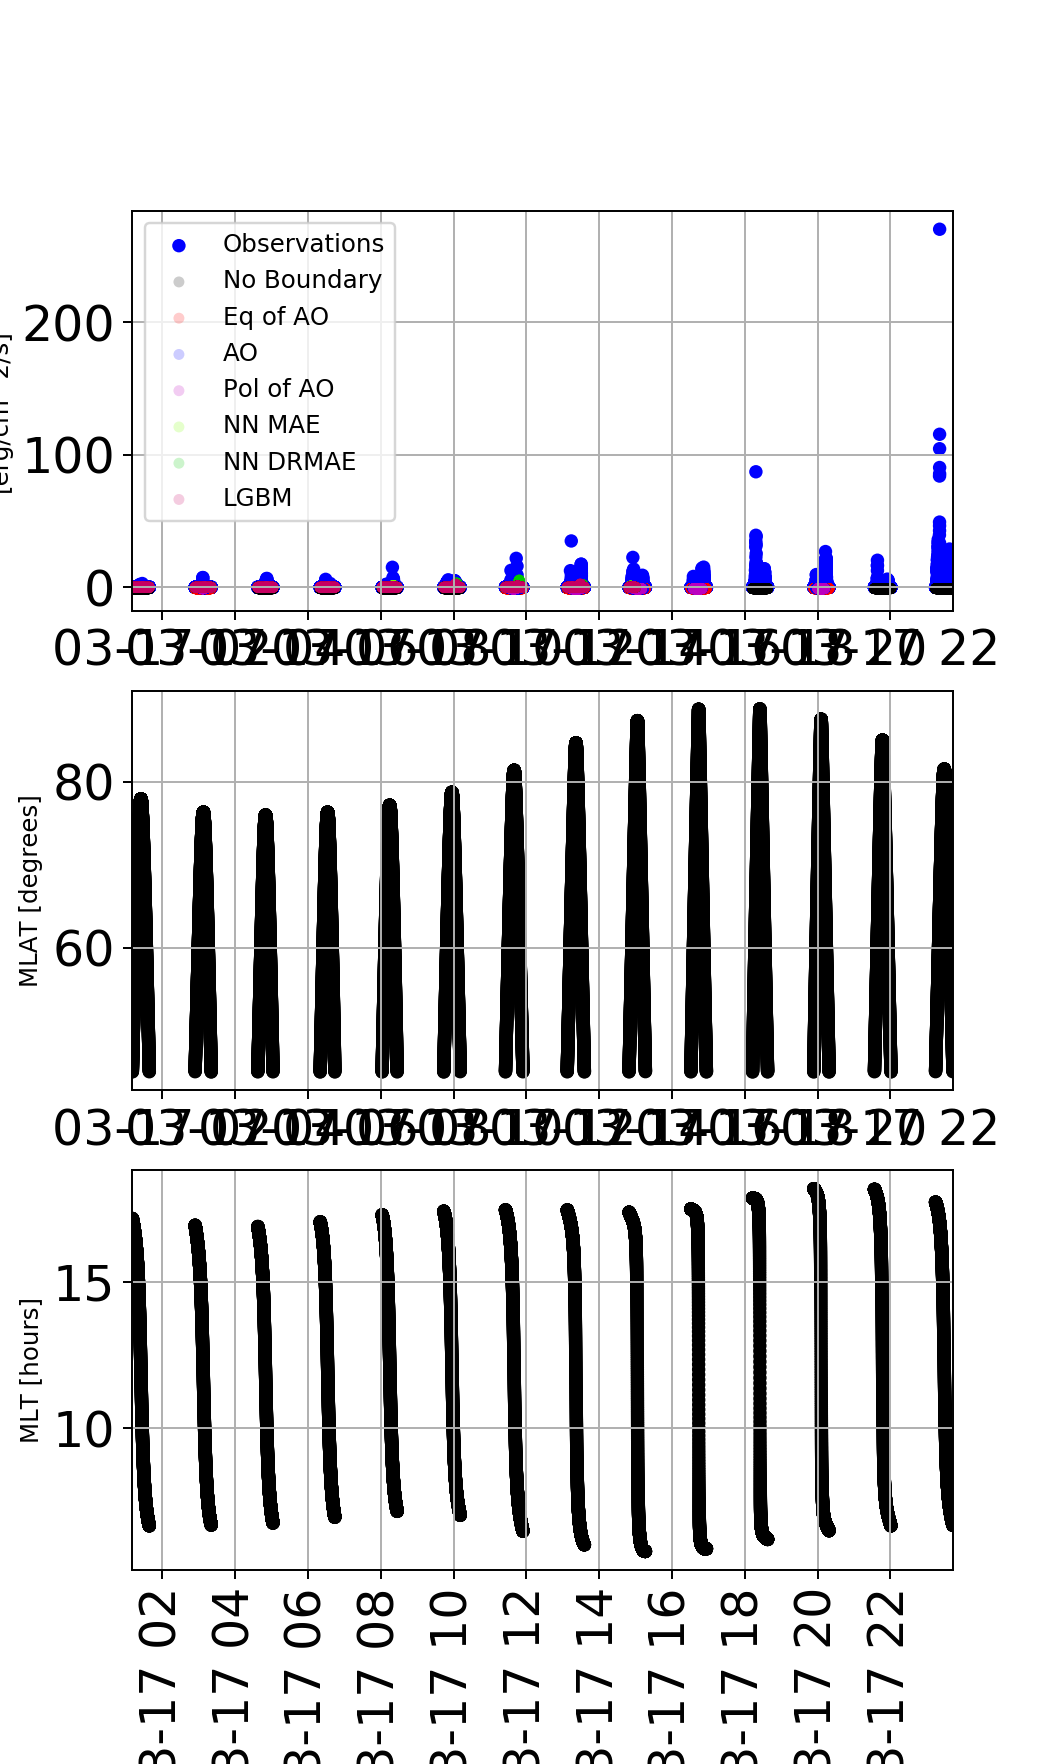

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


In [17]:
%matplotlib notebook
plt.ion()

fig = plt.figure(figsize=(6,10))
gs = GridSpec(3,1, figure=fig)

ax0 = plt.subplot(gs[0,0])
ax_out0 = ax0.scatter(df_f17_reduced.index,
                      df_f17_reduced['ELE_TOTAL_ENERGY_FLUX'] * (1.60218e-12 * np.pi),
#                       df_f17_reduced['ELE_TOTAL_ENERGY_FLUX'] * (np.pi),
                      c = 'b',
                      alpha = 1,
                      s=30, 
                      edgecolor='',
                      label='Observations'
           )
aur_bounds_line = -1.
ax0.scatter(df_f17_reduced[df_f17_reduced['AURORAL_REGION']==0].index,
            np.tile(aur_bounds_line,(len(df_f17_reduced[df_f17_reduced['AURORAL_REGION']==0]),1)),
            c = 'k',
            alpha = 0.2,
            s=20, 
            edgecolor='',
            label='No Boundary'
           )
ax0.scatter(df_f17_reduced[df_f17_reduced['AURORAL_REGION']==1].index,
            np.tile(aur_bounds_line,(len(df_f17_reduced[df_f17_reduced['AURORAL_REGION']==1]),1)),
            c = 'r',
            alpha = 0.2,
            s=20, 
            edgecolor='',
            label='Eq of AO'
           )
ax0.scatter(df_f17_reduced[df_f17_reduced['AURORAL_REGION']==2].index,
            np.tile(aur_bounds_line,(len(df_f17_reduced[df_f17_reduced['AURORAL_REGION']==2]),1)),
            c = 'b',
            alpha = 0.2,
            s=20, 
            edgecolor='',
            label='AO'
           )
ax0.scatter(df_f17_reduced[df_f17_reduced['AURORAL_REGION']==3].index,
            np.tile(aur_bounds_line,(len(df_f17_reduced[df_f17_reduced['AURORAL_REGION']==3]),1)),
            c = 'm',
            alpha = 0.2,
            s=20, 
            edgecolor='',
            label='Pol of AO'
           )


ax0.scatter(y_loop_predictions_save.index,
            (10**y_loop_predictions_save['predictions-NN MAE'])*(1.60218e-12),
#             (10**y_loop_predictions_save['predictions-NN MAE']),
            c = [127/255.,255/255.,0/255.],
            alpha = 0.2,
            s=20, 
            edgecolor='',
            label='NN MAE'
           )


ax0.scatter(y_loop_predictions_save.index,
            (10**y_loop_predictions_save['predictions-NN DRMAE'])*(1.60218e-12),
#             (10**y_loop_predictions_save['predictions-NN DRMAE']),
            c = [0/255.,204/255.,0/255.],
            alpha = 0.2,
            s=20, 
            edgecolor='',
            label='NN DRMAE'
           )

ax0.scatter(y_loop_predictions_save.index,
            (10**y_loop_predictions_save['predictions-LGBM'])*(1.60218e-12),
#             (10**y_loop_predictions_save['predictions-LGBM']),
            c = [204/255.,0/255.,102/255.],
            alpha = 0.2,
            s=20, 
            edgecolor='',
            label='LGBM'
           )

ax0.set_xlim([df_f17_reduced.index[0],df_f17_reduced.index[-1]])
# ax0.set_ylim([-1.5,200])
ax0.grid(True)
ax0.set_ylabel('[erg/cm^2/s]')
# ax0.set_ylabel('log10[ev/cm^2/s/str]')
ax0.set_xticklabels('')
ax0.legend()


ax3 = plt.subplot(gs[1,0],sharex=ax0)
ax_out = ax3.scatter(df_f17_reduced.index,
                     df_f17_reduced['SC_AACGM_LAT'],
                     alpha = 1.0,
                     c = 'k',
                     s=30, 
                     edgecolor='',
           )
ax3.set_xlim([df_f17_reduced.index[0],df_f17_reduced.index[-1]])
ax3.grid(True)
ax3.set_ylabel('MLAT [degrees]')
ax3.set_xticklabels('')


ax4 = plt.subplot(gs[2,0],sharex=ax0)
ax_out = ax4.scatter(df_f17_reduced.index,
                     df_f17_reduced['SC_AACGM_LTIME'],
                     alpha = 1.0,
                     c = 'k',
                     s=30, 
                     edgecolor='',
           )
ax4.set_xlim([df_f17_reduced.index[0],df_f17_reduced.index[-1]])
ax4.grid(True)
ax4.set_ylabel('MLT [hours]')
# ax4.set_xticklabels('')



plt.xticks(rotation = 90)

plt.show()

In [57]:
# 10**y_loop_predictions_save['predictions'].iloc[0:1000] * (1.60218e-12)
np.argwhere( y_loop_predictions_save['predictions'].isnull() == True )

/anaconda3/envs/python36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


array([], shape=(0, 1), dtype=int64)

In [58]:


y_loop_predictions_save.to_csv(os.path.join(filedirectory,'y_loop_predictions_save--f17--March17_2015.csv'),na_rep='NaN',index=True,header=True)



In [59]:
filedirectory

'/Users/ryanmcgranaghan/Documents/DMSPdata/2015/'

###### Create the predictions at each time step - full grid (not completed yet)

In [ ]:
predictions_input_list = input_features_labels

for d in predict_datetimes:
    print('working on datetime = {}'.format(d))


    doy_loop = d.timetuple().tm_yday
    ut_loop = d.hour*3600 + d.minute*60 + d.second

    doy_sin_loop = np.tile(np.sin(2*np.pi*doy_loop/365.),(shape_grid_flat,1))
    doy_cos_loop = np.tile(np.cos(2*np.pi*doy_loop/365.),(shape_grid_flat,1))

    ut_sin_loop = np.tile(np.sin(2*np.pi*ut_loop/86400.),(shape_grid_flat,1))
    ut_cos_loop = np.tile(np.cos(2*np.pi*ut_loop/86400.),(shape_grid_flat,1))

    df_loop = pd.DataFrame(columns=predictions_input_list)

    idx_SW_loop = nearest(SW_df_1s.index,d)
    print('nearest index in solar wind data is {} (datetime = {})'.format(idx_SW_loop,SW_df_1s.index[idx_SW_loop]))
    SW_data_loop = SW_df_1s.iloc[idx_SW_loop]

    df_loop['SC_AACGM_LAT'] = predict_locations[:,0]
    df_loop['sin_SC_AACGM_LTIME'] = predict_locations[:,1]
    df_loop['cos_SC_AACGM_LTIME'] = predict_locations[:,2]

    df_loop['ID_SC'] = 16.0

    df_loop['sin_ut'] = ut_sin_loop
    df_loop['cos_ut'] = ut_cos_loop

    df_loop['sin_doy'] = doy_sin_loop
    df_loop['cos_doy'] = doy_cos_loop


    for col in df_loop.columns:
        if (col in SW_df_1s.columns):
            df_loop[col] = np.tile( SW_df_1s[col].iloc[idx_SW_loop],(shape_grid_flat,1) )

    # Quick catch for bad data
    if (np.any(pd.isnull(df_loop.values[0,:]))):
        print('\n\n\n\nWARNING: input data had NaN value(s) at datetime = {}\n\n\n\n'.format(d))


    print('data_loop shape = {}'.format(df_loop.shape))
    
    

    # ----------------------------------------------------------------------------------
    #           Make Predictions
    # ----------------------------------------------------------------------------------
    y_loop_predictions = model.predict( scaler_X.transform(df_loop.values) )
    y_loop_predictions_grid = np.reshape(y_loop_predictions,(mlat_grid.shape[0],mlat_grid.shape[1]))
    # ----------------------------------------------------------------------------------
    # ----------------------------------------------------------------------------------

    # ----------------------------------------------------------------------------------
    #           Get OVATION Prime Predictions
    # ----------------------------------------------------------------------------------
    flag = 0
    for a_type in auroral_flux_types:
        print('working on auroral_flux_type = {}'.format(a_type))
        estimator_e = ovation_prime.FluxEstimator(a_type,energy_or_number='energy')
        mlat_grid_ovation, mlt_grid_ovation, eFlux_ovation_tmp = estimator_e.get_flux_for_time(d,
                                                                                         hemi=hemi,
                                                                                         return_dF=False,
                                                                                         combine_hemispheres=True,)
        estimator_n = ovation_prime.FluxEstimator(a_type,energy_or_number='number')
        _, _, nFlux_ovation_tmp = estimator_n.get_flux_for_time(d,
                                                                hemi=hemi,
                                                                return_dF=False,
                                                                combine_hemispheres=True,)

        if flag == 0:
            eFlux_ovation_full = eFlux_ovation_tmp
            nFlux_ovation_full = nFlux_ovation_tmp
            flag = 1
        elif flag == 1:
            eFlux_ovation_full = eFlux_ovation_full + eFlux_ovation_tmp
            nFlux_ovation_full = nFlux_ovation_full + nFlux_ovation_tmp

        avg_ovation_full = (eFlux_ovation_full/1.6e-12) / nFlux_ovation_full #energy flux Joules->eV
        avg_ovation_full[nFlux_ovation_full<numFluxThreshold] == 0.

    
    # ----------------------------------------------------------------------------------
    #           Save arrays
    # ----------------------------------------------------------------------------------

    # Convert OVATION output erg/cm^2/s to log10(eV/cm^2/s)
    eFlux_ovation_full = np.log10(eFlux_ovation_full * 6.242e+11)
    eFlux_ovation_full[np.isinf(eFlux_ovation_full)] = np.nan
    
    # Convert ML model output log10(eV/cm^2/s/ster) to log10(eV/cm^2/s)
#     y_loop_predictions = y_loop_predictions*np.pi
        # RMM 2.12.2020: I believe you need to first take the inverse of the log10 operation 
        #   to get to appropriate units to then remove the steradian (pi) from the data
    y_loop_predictions = np.log10( (10**(y_loop_predictions))*np.pi )
    
    # Save the prediction dataframe (one file per datetime)
    df_loop_save = pd.DataFrame(np.column_stack((np.reshape( mlat_grid,(shape_grid_flat) ),
                                                 np.reshape( mlt_grid,(shape_grid_flat) ),
                                                 y_loop_predictions,
                                                 np.reshape( eFlux_ovation_full,(shape_grid_flat) )
                                                )),
                                columns=['mlat','mlt','ML prediction [log10 eV/cm^2/s]','OVATION prediction [log10 eV/cm^2/s]'] )
    
    # Calculate the Hemispheric power and auroral boundaries
    ML_converted_W = ( 10 ** np.reshape(df_loop_save['ML prediction [log10 eV/cm^2/s]'].values, (mlat_grid.shape[0],mlat_grid.shape[1]) ) ) * (1.60218e-12) * (100**2) / 1e7
    ML_converted_erg = ( 10 ** np.reshape(df_loop_save['ML prediction [log10 eV/cm^2/s]'].values, (mlat_grid.shape[0],mlat_grid.shape[1]) ) ) * (1.60218e-12)
    OVATION_converted_W = ( 10 ** np.reshape(df_loop_save['OVATION prediction [log10 eV/cm^2/s]'].values, (mlat_grid.shape[0],mlat_grid.shape[1]) ) ) * (1.60218e-12) * (100**2) / 1e7
    OVATION_converted_erg = ( 10 ** np.reshape(df_loop_save['OVATION prediction [log10 eV/cm^2/s]'].values, (mlat_grid.shape[0],mlat_grid.shape[1]) ) ) * (1.60218e-12)
    
    

##### Generate OVATION Prime validation data